# Стартапы

## 0.Описание проекта

### 0.1.Задача проекта

Разработать модель для предсказания успешности стартапа (закроется или нет)

### 0.2.Описание данных

Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'

- kaggle_startups_train_01.csv - информация (53 000) стартапах, которые будут использоваться в качестве обучающих данных.
- kaggle_startups_test_01.csv - информация (13 000) стартапах, которые будут использоваться в качестве тестовых данных. Наша задача - предсказать значение 'status' для каждого стартапа из этого датасета.
 - kaggle_startups_sample_submit_01.csv - файл с примером предсказаний в правильном формате.
name - идентификатор (название) стартапа в тестовом наборе.
status - целевой признак. Для каждого стартапа необходимо предсказать категориальное значение соответствующее прогнозу ['operating', 'closed'].

### 0.3.Описание полей данных

- name - Название стартапа
- category_list - Список категорий, к которым относится стартап
- funding_total_usd - Общая сумма финансирования в USD
- status - Статус стартапа (закрыт или действующий)
- country_code - Код страны
- state_code - Код штата
- region - Регион
- city - Город
- funding_rounds - Количество раундов финансирования
- founded_at - Дата основания
- first_funding_at - Дата первого раунда финансирования
- last_funding_at - Дата последнего раунда финансирования
- closed_at - Дата закрытия стартапа (если применимо)
- lifetime - Время существования стартапа в днях

### 0.4.План выполения проекта

- загрузка и ознакомление с данными,
- предварительная обработка,
- полноценный разведочный анализ,
- разработка новых синтетических признаков,
- проверка на мультиколлинеарность,
- отбор финального набора обучающих признаков,
- выбор и обучение моделей,
- итоговая оценка качества предсказания лучшей модели,
- анализ важности ее признаков,
- подготовка отчета по исследованию.

## 1. Загрузка и подготовка данных

### 1.1. Чтение данных

In [554]:
# Установим необходимые библиотеки
!pip install phik
!pip install -U scikit-learn

In [555]:
# Импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns

from scipy import stats as st

from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik
import os

pd.set_option('display.float_format', '{:.2f}'.format)

In [556]:
RANDOM_STATE = 42

In [557]:
sample_submit = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')
test = pd.read_csv('kaggle_startups_test_28062024.csv')
train = pd.read_csv('kaggle_startups_train_28062024.csv')

In [558]:
# Проверим размеры получившихся датасетов
print(sample_submit.shape)
print(test.shape)
print(train.shape)

(13125, 2)
(13125, 11)
(52516, 13)


### 1.2. Изучение общей информации о датасетах

In [559]:
# Создадим функцию для просмотра общей информации о датасетах
def overview_data(data):
    dash = '-' * 50

    print(dash)
    print('Основная информация о данных')
    print(dash)
    print(data.info())
    print('\n')

    print(dash)
    print('Первые строки данных')
    print(dash)
    print(data.head())
    print('\n')

    print(dash)
    print('Описательная статистика')
    print(dash)
    print(data.describe())
    print('\n')

    print(dash)
    print('Пропущенные значения')
    print(dash)
    print(data.isna().sum())
    print('\n')

    print(dash)
    print('Дубликаты')
    print(dash)
    print(data.duplicated().sum())
    print('\n')

In [560]:
# Выведем общую информацию о датасете train
overview_data(train)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)

In [561]:
# Выведем общую информацию о датасете train
overview_data(test)

--------------------------------------------------
Основная информация о данных
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB
None


--------------------------------------------------
Первые строки да

## 2. Предобработка данных

Будем разбираться с каждой колонкой по отдельности по порядку в датасете train

### 2.1.name

В этой колонке у нас все значения уникальны, есть пропуски в одной строке.

In [562]:
# Посмотрим на нее
train[train['name'].isna()].head()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
3291,NaN,Startups,25000.00,closed,USA,OR,"Portland, Oregon",Portland,1,2011-10-01,2012-03-01,2012-03-01,2013-06-03


In [563]:
# Заменим пропущенное значение на other
train['name'] = train['name'].fillna('other')

### 2.2.category_list

В этой колонке у нас есть пропуски и в некоторых стартапах встречаются несколько категорий разделенных '|'.  Найдем все уникальные категории, и создадим для каждого отдельный столбец. Обозначим 1 если стартап в этой категории и 0 - если нет. Для пропущенных значений создадим категорию other. Попробывал все уникальные категории выделить столбцами, получилось около 800 столбцов. Думаю это слишком много. Буду выбирать только корневую категорию.

In [564]:
# Приведем все категории к нижнему регистру
train['category_list'] = train['category_list'].str.lower()

In [565]:
# Заполним пропуски other
train['category_list'] = train['category_list'].fillna('other')

In [566]:
# Разделим строки по разделителю и выбираем корневую категорию
split_categories = train['category_list'].str.split('|')

# Создадим бинаризатор
mlb = MultiLabelBinarizer()

# Применяем и создадим датафрейм с полученными категориями
categories = pd.DataFrame(mlb.fit_transform(split_categories),
                         columns=mlb.classes_,
                         index=train.index)

# Объединяем с исходными данными
train = pd.concat([train, categories], axis=1)

In [567]:
# Проверим размер полученного датасета
train.shape

(52516, 868)

### 2.3.funding_total_usd

В этой колонке мы можем заменить тип на int т.к. это сумма финансирования в долларах, суммы большие поэтому центы в сумме ни на что не повлияют. Также в колонке есть пропуски, возможно это связано с тем, что компании просто не получали финансирования а использовали свои средства, поэтому заменим пропуски нулями.

In [568]:
# Заменим пропуски на 0
train['funding_total_usd'] = train['funding_total_usd'].fillna(0)

In [569]:
# Заменим тип данных на int
train['funding_total_usd'] = train['funding_total_usd'].astype(int)

### 2.4.country_code, state_code, region, city

В этих колонках присутствуют пропуски. Заменим их на other

In [570]:
# Заменим пропущенные значение на other
cols_to_fill = ['country_code', 'state_code', 'region', 'city']
train[cols_to_fill] = train[cols_to_fill].fillna('other')

### 2.5.founded_at, first_funding_at, last_funding_at, closed_at

В этих колонках не верный тип данных object вместо datetime. Изменим тип данных на верный. Также есть пропуски в колонке closed_at - думаю это означает то, что компания до сих пор существует. Также в датасете тест есть колонка lifetime которой нет в датасете train. Создадим ее как разницу между датой закрытия компании и датой основания.

In [571]:
# Приведем все даты к нужному типу
date_cols = ['founded_at', 'first_funding_at', 'last_funding_at', 'closed_at']
train[date_cols] = train[date_cols].apply(pd.to_datetime, errors='coerce')

In [572]:
# Заполним пропуски в столбце closed_at текущей датой
train['closed_at'] = train['closed_at'].fillna(pd.to_datetime(datetime.now().date()))

In [573]:
# Создадим стобец lifetime
train['lifetime'] = (train['closed_at'] - train['founded_at']).dt.days

In [574]:
# Удалим лишние столбцы после трансвформаций
# Список столбцов для удаления
columns_to_drop = ['founded_at', 'category_list', 'closed_at']
train = train.drop(columns=columns_to_drop)

## 3.Анализ признаков

In [586]:
# Создадим датасет для анализа признаков без бинаризированных
train_b = train.drop(columns=categories.columns).copy()
train_b = train_b.drop(columns='name')

In [587]:
train_b.head()

,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,828626,operating,CHE,25,Zurich,Zürich,2,2011-05-01,2014-12-01,5638
1,42935019,operating,USA,CA,SF Bay Area,Redwood City,4,2010-05-04,2014-02-25,7388
2,35456381,operating,USA,CA,SF Bay Area,San Jose,3,2012-08-20,2014-07-02,7023
3,22250000,operating,other,other,other,other,3,2011-09-01,2014-07-18,7754
4,0,operating,USA,VA,VA - Other,Bristol,1,2012-02-01,2012-02-01,5431


In [588]:
# Функция построения диаграмм для числовых признаков
def num_diag(data, x, xlabel, ylabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.histplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0],
        stat="density",
        common_norm=False
    )
    axes[0].set_title(f'Гистограмма по {xlabel}')
    axes[0].set_xlabel(xlabel)
    axes[0].set_ylabel(ylabel)

    sns.boxplot(
        data=data,
        x=x,
        ax=axes[1]
    )
    axes[1].set_title(f'Диаграмма размаха {xlabel}')
    axes[1].set_xlabel(xlabel)
    axes[1].set_ylabel(ylabel)

    plt.tight_layout()
    plt.show()

In [589]:
# Функция построения диаграмм для категориальных признаков
def cat_diag(data, x, xlabel, hue=None):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.countplot(
        data=data,
        x=x,
        hue=hue,
        ax=axes[0]
    )
    axes[0].set_title(f'Диаграмма по {xlabel}')
    axes[0].set_ylabel('Количество')
    axes[0].set_xlabel(xlabel)
    axes[0].tick_params(axis='x', rotation=45)

    data[x].value_counts(normalize=True).plot(
        kind='pie',
        labels=data[x].value_counts(normalize=True).index,
        legend=False,
        autopct='%1.0f%%',
        ax=axes[1]
    )
    axes[1].set_title(f'Распределение долей {xlabel}')
    axes[1].set_ylabel('')

    plt.tight_layout()
    plt.show()

In [590]:
# Создадим функцию для автоматической визуализации признаков в зависимости от типа колонки
def all_diag(df, column_type='numeric', hue=None):
    if column_type == 'numeric':
        columns = df.select_dtypes(include='number').columns
    elif column_type == 'categorical':
        columns = df.select_dtypes(include='object').columns

    for col in columns:
        if column_type == 'numeric':
            print(f"Визуализация численного признака: {col}")
            num_diag(df, x=col, xlabel=col, ylabel='Плотность распределения', hue=hue)
        elif column_type == 'categorical':
            print(f"Визуализация категориального признака: {col}")
            cat_diag(df, x=col, xlabel=col, hue=hue)

Визуализация численного признака: funding_total_usd


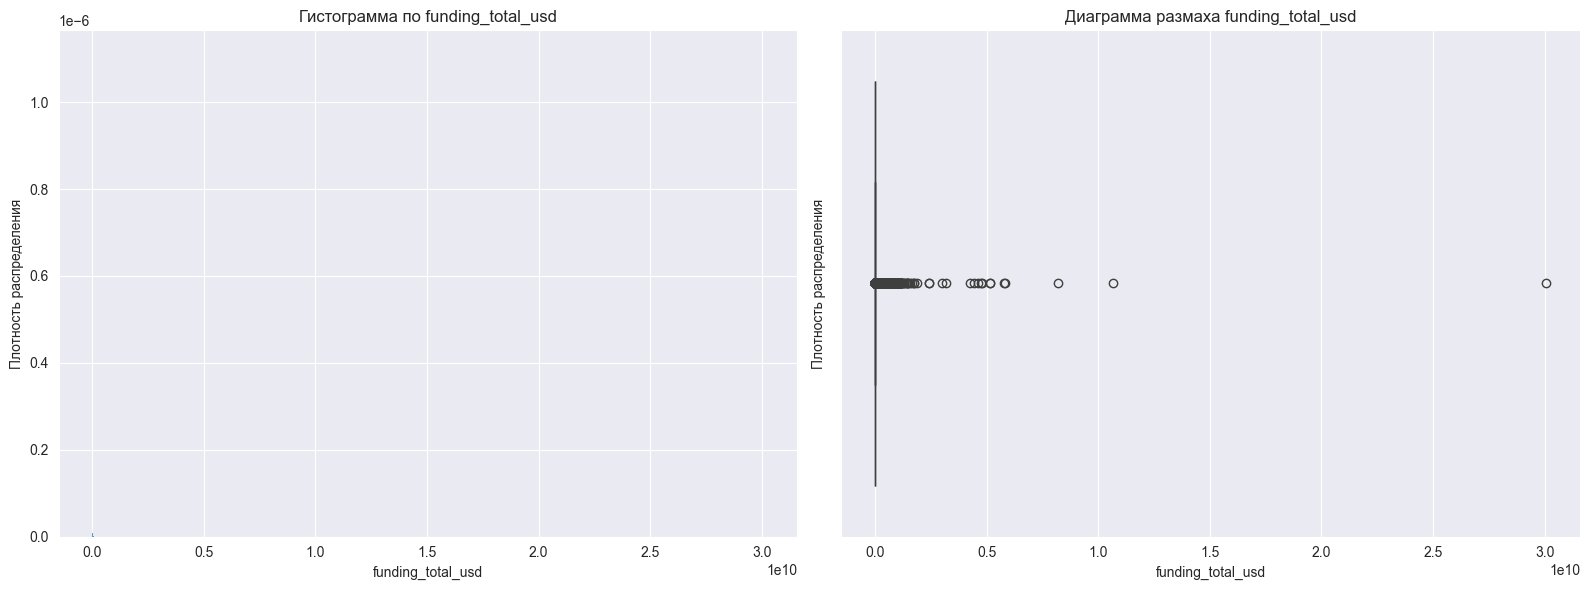

Визуализация численного признака: funding_rounds


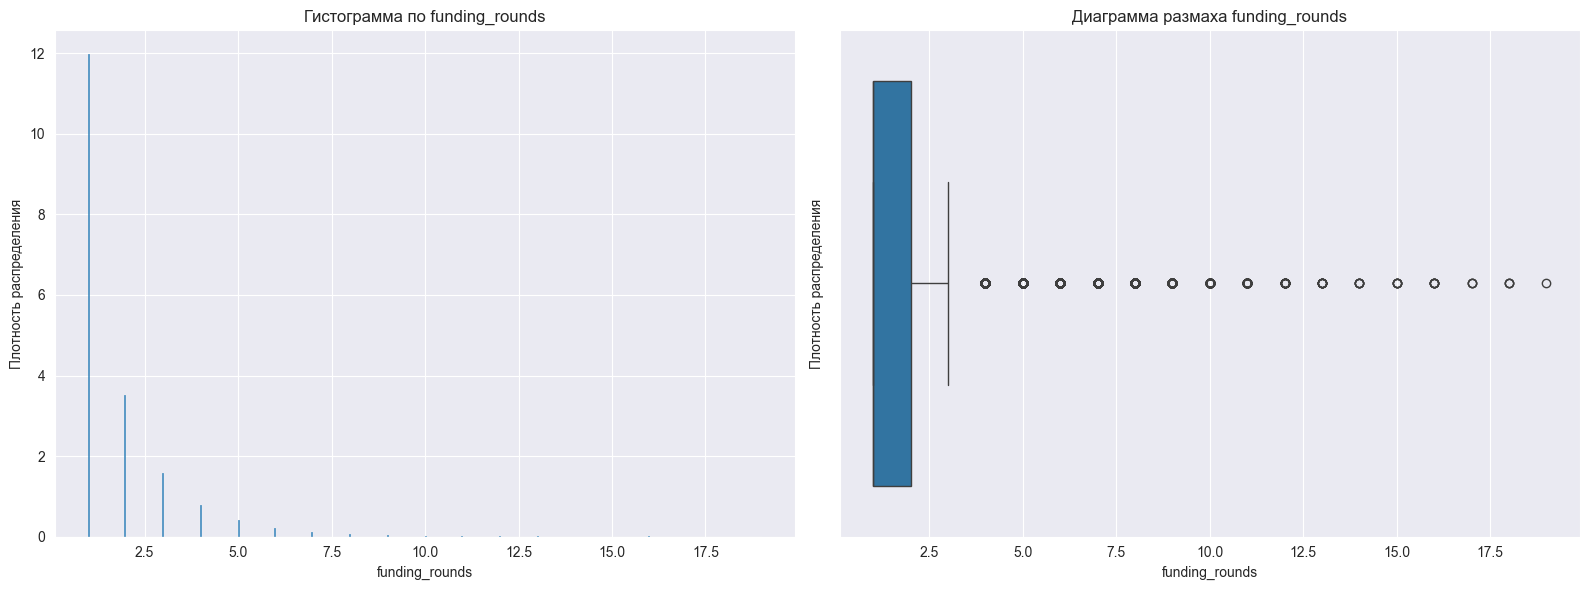

Визуализация численного признака: lifetime


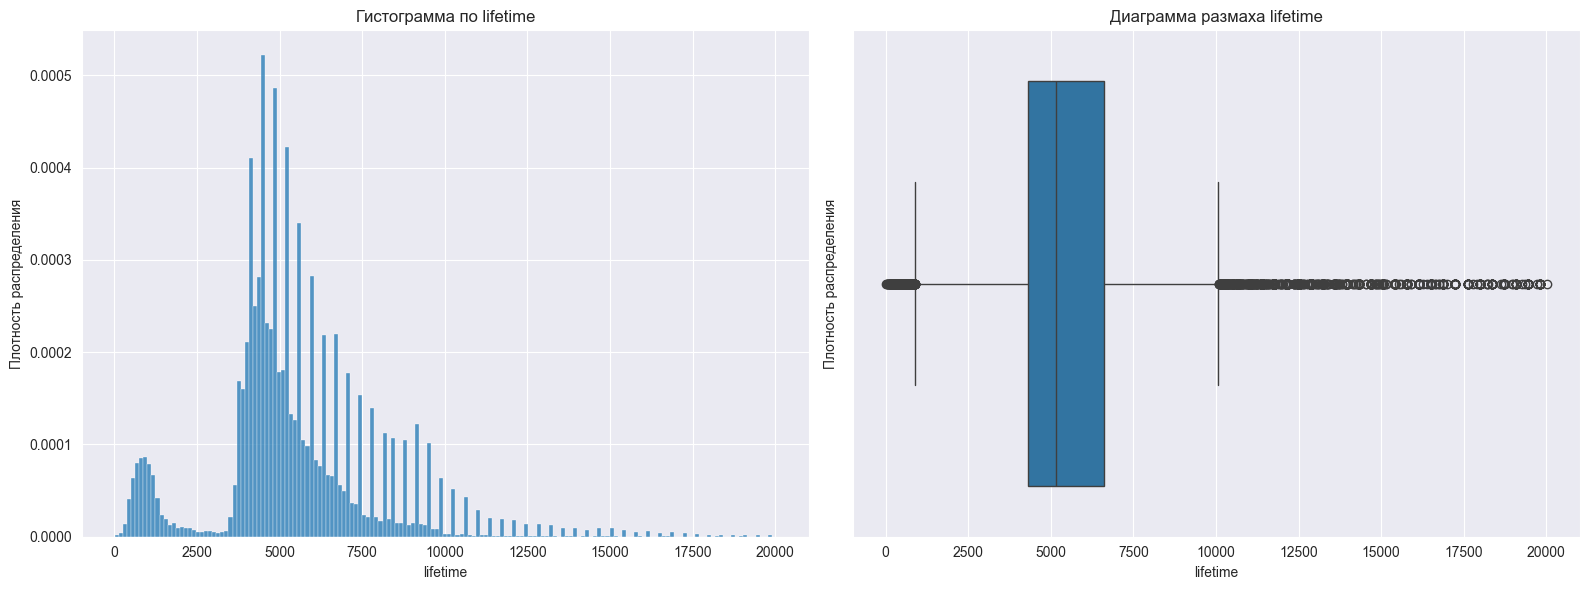

In [580]:
all_diag(train_b, column_type='numeric', hue=None)

Визуализация категориального признака: status


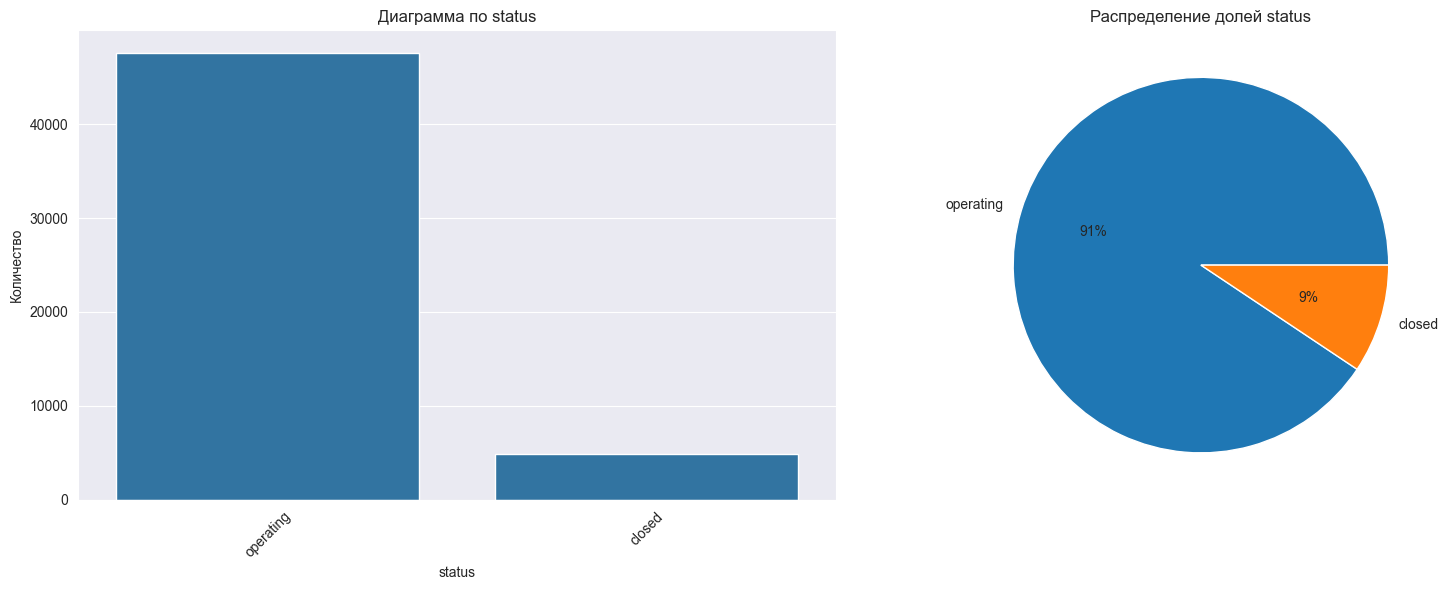

Визуализация категориального признака: country_code


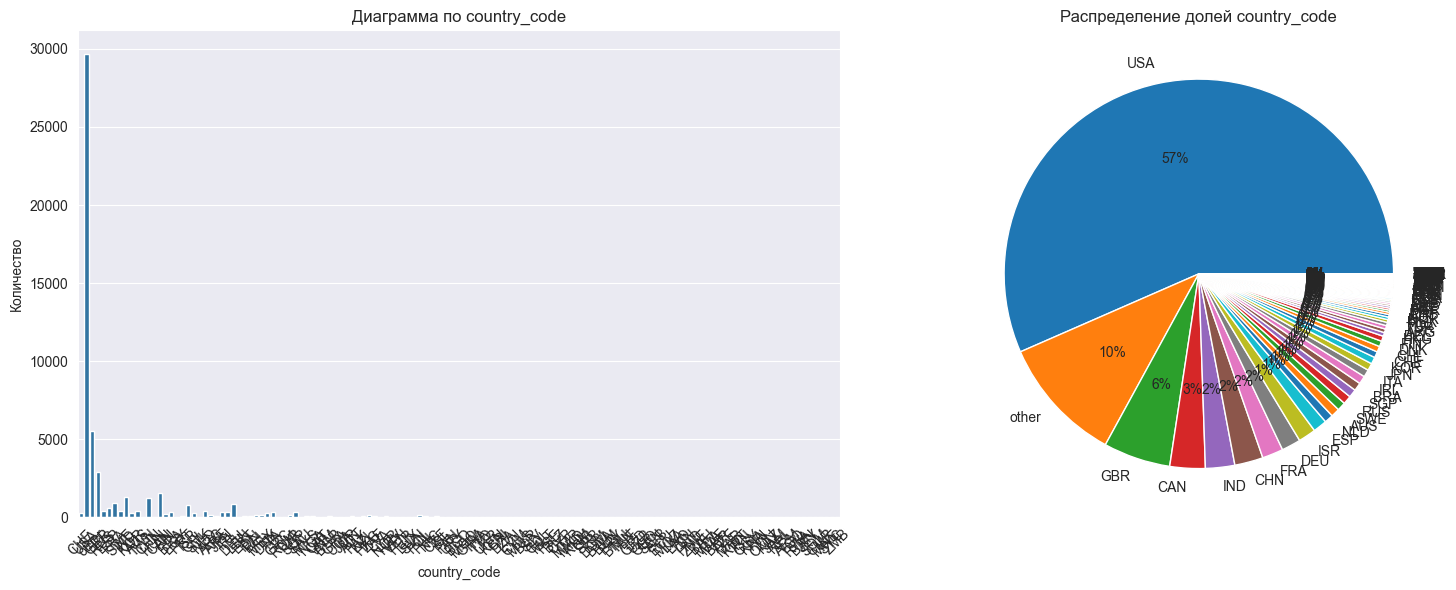

Визуализация категориального признака: state_code


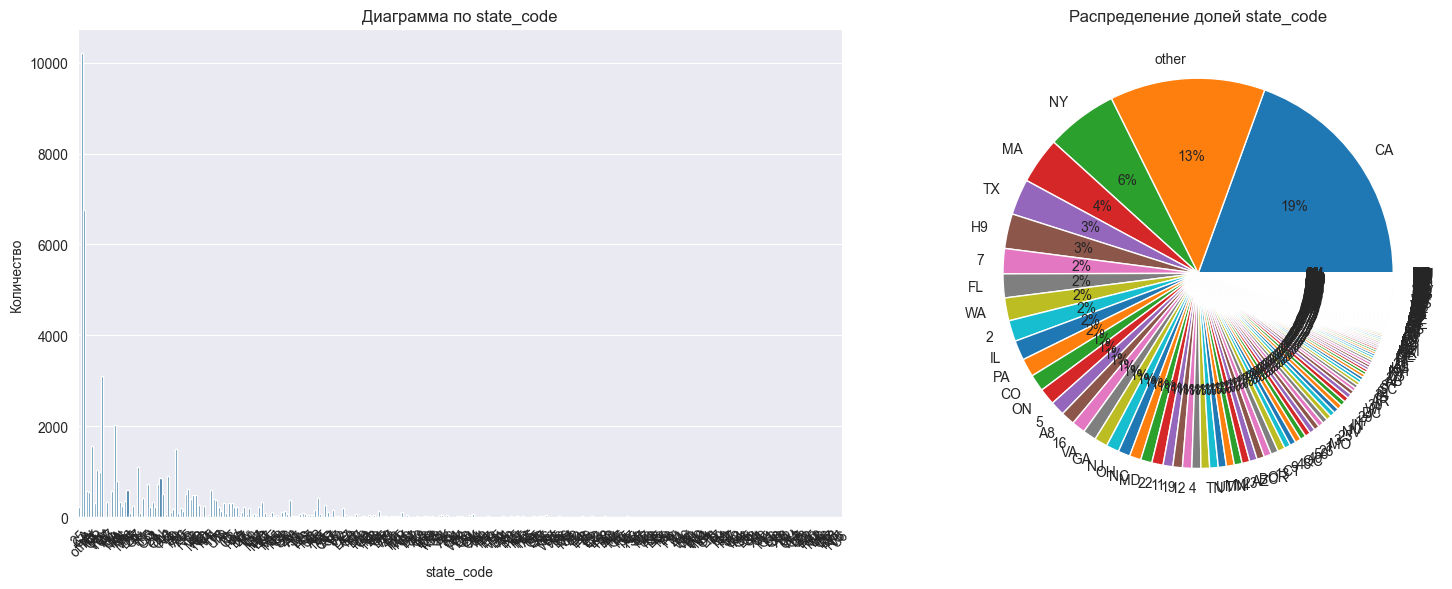

Визуализация категориального признака: region


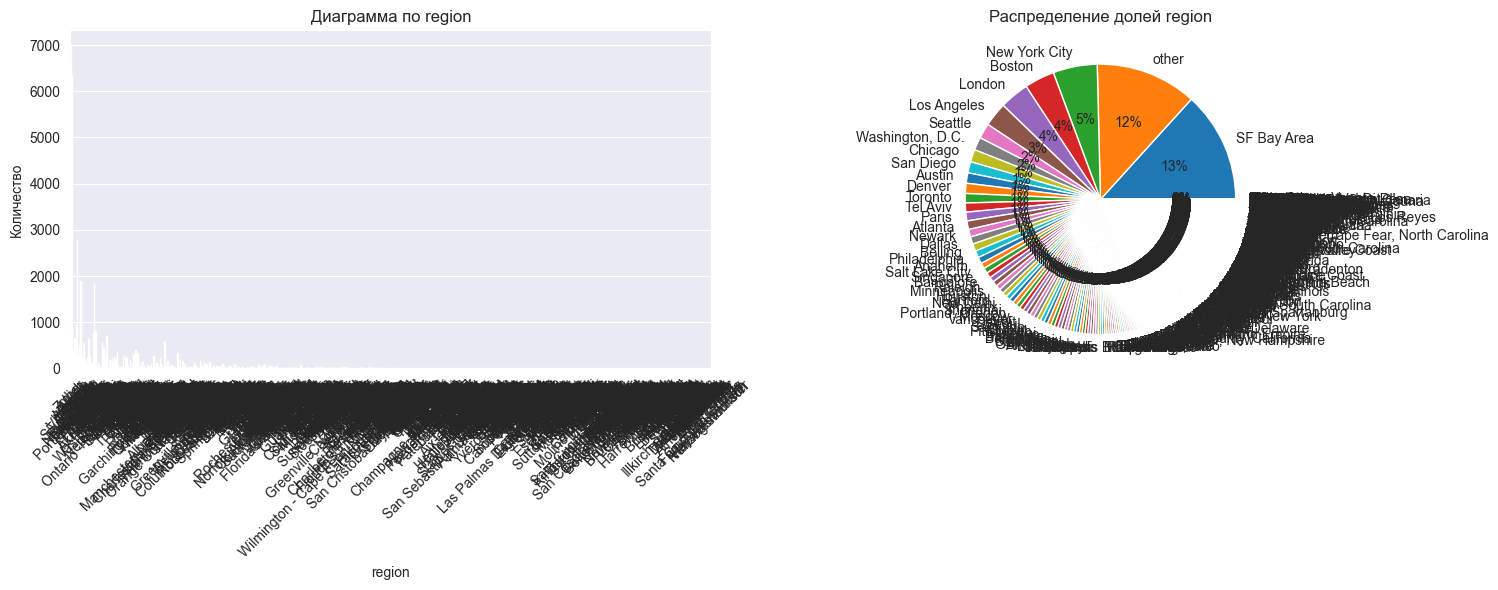

Визуализация категориального признака: city


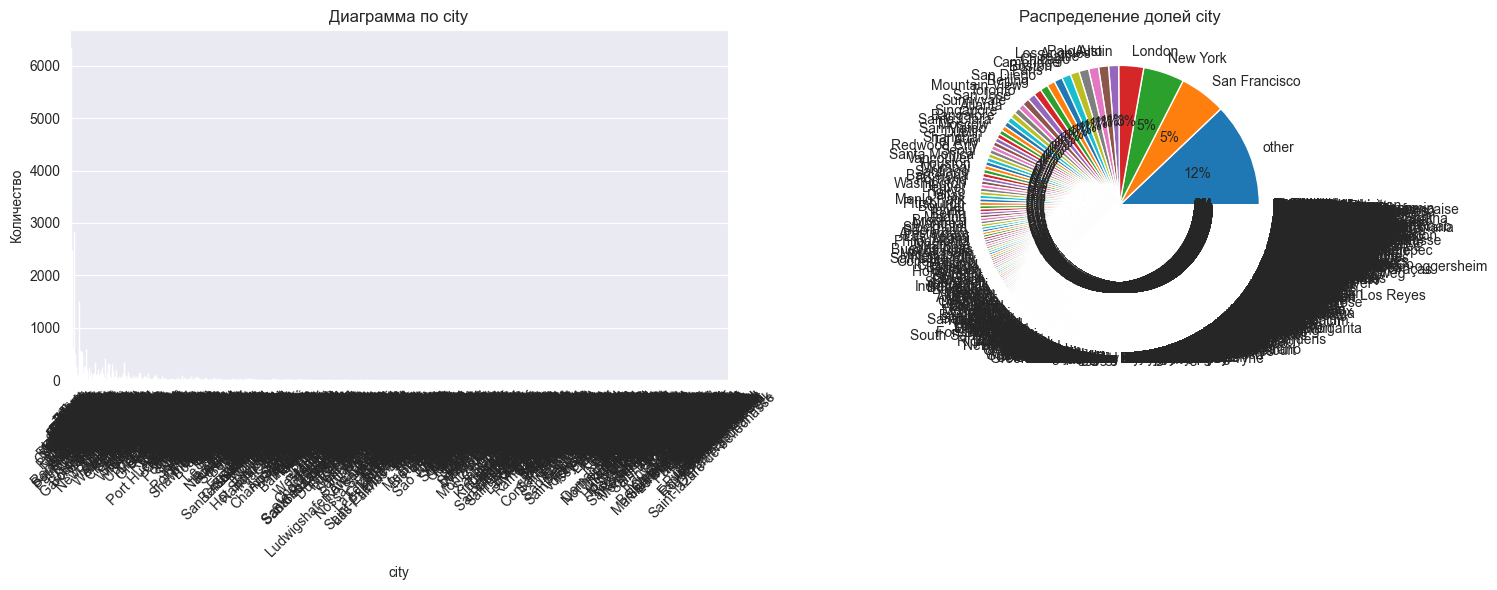

In [591]:
all_diag(train_b, column_type='categorical', hue=None)